# Implement recurrent nova with using the Galactic class

This is a preliminary documentation for an example showing a fully user implemented/modified model for a recurrent nova. 

## loading test data

In the following we reproduce the results published in the  MAGIC [paper](https://ui.adsabs.harvard.edu/abs/2022NatAs...6..689A/abstract)  Nature Astronomy, Volume 6, p. 689-697

In [1]:
from jetset.jet_model import GalacticUnbeamed
from astropy import constants
from astropy import units as u


![non relativistic expanding shell](../../images/exp_non_rel_shell.png )

In [2]:
from jetset.data_loader import Data
data_fermi=Data.from_file(data_table='./data/fermi_day3.ecsv')
data_magic=Data.from_file(data_table='./data/magic_day3.ecsv')

In [3]:
from astropy.table import Table, vstack
data_table=vstack([data_fermi.table,data_magic.table])
data=Data(n_rows=len(data_table))

In [4]:
from jetset.data_loader import ObsData
sed_data=ObsData(data_table=data_table)


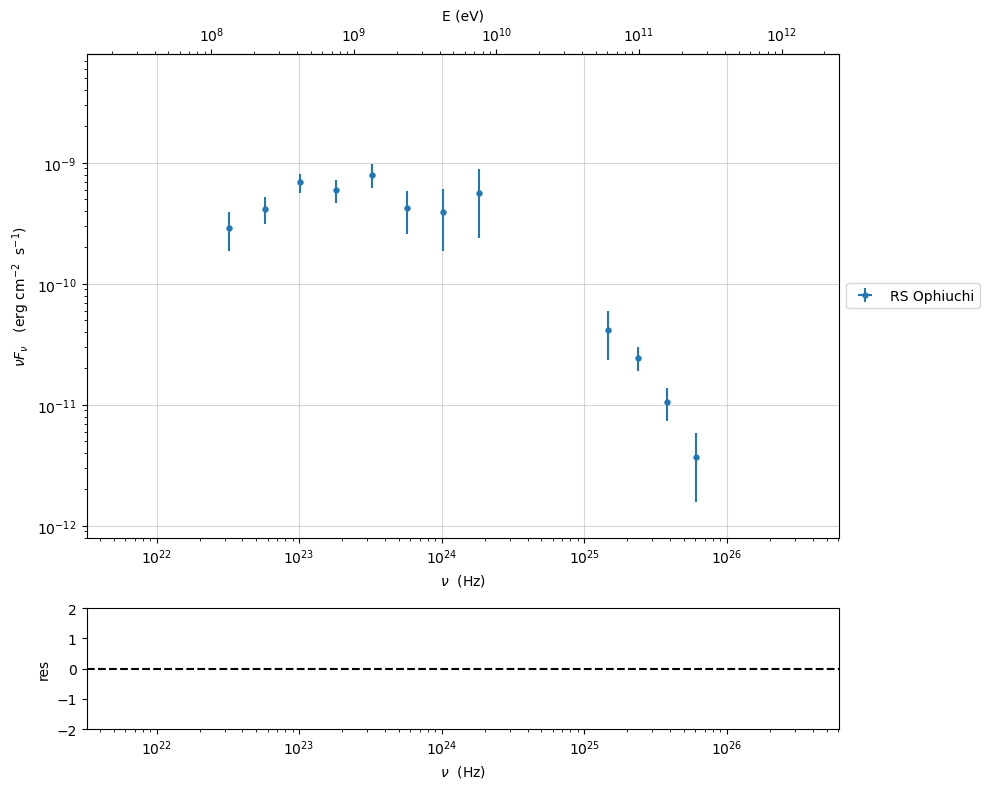

In [5]:
sed_data.plot_sed()

## setting up an expanding shell

In [6]:
def build_expanding_spherical_shell(sync='on',add_EC_star=False,emitters_type='electrons',emitters_distribution='bkn'):
    j=GalacticUnbeamed(emitters_distribution=emitters_distribution,geometry='spherical_shell',emitters_type=emitters_type)
    
    if add_EC_star is True:
        j.add_EC_component('EC_Star')
        j.parameters.theta_Star.val=0
        
    j.add_user_par(name='v_sh',units='km s-1',val=1E3,val_min=0,val_max=None)
    j.add_user_par(name='t',units='d',val=3,val_min=0,val_max=None)

    def par_func(t,v_sh):
        return 1.2E14*(v_sh/4500)*(t/3)

    j.make_dependent_par(par='R_sh', depends_on=['t', 'v_sh'], par_expr=par_func)
    j.make_dependent_par(par='R_H_Star', depends_on=['t', 'v_sh'], par_expr=par_func)
    j.spectral_components.Sync.state=sync
    return j

In [7]:
def build_nova_expanding_shell(E_k=1E40,emitters_type='electrons',emitters_distribution='bkn'):
    j_spherical_shell=build_expanding_spherical_shell(add_EC_star=True,sync='self-abs',emitters_type=emitters_type,emitters_distribution=emitters_distribution)
   
    j_spherical_shell.parameters.B.val=1E-3
    j_spherical_shell.parameters.T_Star.val=6000
    j_spherical_shell.parameters.gmax.val=1E3
    j_spherical_shell.parameters.v_sh.val=4500
    j_spherical_shell.parameters.L_Star.val=4E43

    j_spherical_shell.set_external_field_transf('disk')
    x=u.M_sun
    j_spherical_shell.add_user_par(name='M_ej',units=x,val=0.1,val_min=0,val_max=None)

   
    def par_func_N(M_ej,R_sh,h_sh):
        """ 
        determines the accelerated proton density from M_ej and shell volume
        Eq. 4 in the paper
        
        """
        vol=4/3*np.pi*R_sh**3*((1+h_sh)**3 -1)*u.Unit('cm3')

        N= M_ej.cgs/(vol*constants.m_p.cgs)
        
        return N
    
    if emitters_type == 'protons':
        j_spherical_shell.add_user_par('NH_pp_ratio',val=1E-5,val_min=0, val_max=1000)
        
        def par_func_NH_pp(N,NH_pp_ratio):
            """
            This should come form Eq. 5, but I did not find the relevant parameters in the paper.
            Anyhow, the n_ej>>n_target, I paramtrize it as function of n_je i.e. accelerated proton density
            """
            return N*NH_pp_ratio
        
        j_spherical_shell.make_dependent_par(par='NH_pp', depends_on=['N','NH_pp_ratio'], par_expr=par_func_NH_pp)
        
    j_spherical_shell.make_dependent_par(par='N', depends_on=['M_ej', 'R_sh','h_sh'], par_expr=par_func_N)
    
    def par_func_M_ej(E_k,v_sh):
        """
        mass of the ejecta from Eq. 11
        """
        return (2*E_k*u.erg/(v_sh.cgs)**2)/((u.M_sun).to('g'))

    j_spherical_shell.add_user_par(name='E_k',units='erg',val=1E40,val_min=0,val_max=None)


    j_spherical_shell.make_dependent_par(par='M_ej', depends_on=['E_k','v_sh'], par_expr=par_func_M_ej)
    j_spherical_shell.parameters.E_k.val=1E42
    return j_spherical_shell



===> setting C threads to 12
adding par: t to  R_sh
adding par: v_sh to  R_sh
==> par R_sh is depending on ['t', 'v_sh'] according to expr:   R_sh =
    def par_func(t,v_sh):
        return 1.2E14*(v_sh/4500)*(t/3)

adding par: t to  R_H_Star
adding par: v_sh to  R_H_Star
==> par R_H_Star is depending on ['t', 'v_sh'] according to expr:   R_H_Star =
    def par_func(t,v_sh):
        return 1.2E14*(v_sh/4500)*(t/3)

adding par: N to  NH_pp
adding par: NH_pp_ratio to  NH_pp
==> par NH_pp is depending on ['N', 'NH_pp_ratio'] according to expr:   NH_pp =
        def par_func_NH_pp(N,NH_pp_ratio):
            """
            This should come form Eq. 5, but I did not find the relevant parameters in the paper.
            Anyhow, the n_ej>>n_target, I paramtrize it as function of n_je i.e. accelerated proton density
            """
            return N*NH_pp_ratio

adding par: M_ej to  N
adding par: R_sh to  N
adding par: h_sh to  N
==> par N is depending on ['M_ej', 'R_sh', 'h_sh'] accordin

name,type,units,val
BulkLorentzFactor,jet-bulk-factor,,1.000000e+00
U_e,Energy dens. rest. frame,erg / cm3,5.019236e-02
U_B,Energy dens. rest. frame,erg / cm3,3.978874e-08
U_p,Energy dens. rest. frame,erg / cm3,1.234015e+06
U_p_target,Energy dens. rest. frame,erg / cm3,5.557468e+00
U_Synch,Energy dens. rest. frame,erg / cm3,3.531297e-14
U_Disk,Energy dens. rest. frame,erg / cm3,0.000000e+00
U_BLR,Energy dens. rest. frame,erg / cm3,0.000000e+00
U_DT,Energy dens. rest. frame,erg / cm3,0.000000e+00
U_CMB,Energy dens. rest. frame,erg / cm3,0.000000e+00


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
galactic_unbeamed_hadronic_pp,B,magnetic_field,gauss,1.000000e-03,0.000000e+00,--,False,False
galactic_unbeamed_hadronic_pp,"*R_sh(D,v_sh)",region_size,cm,1.200000e+14,1.000000e+03,1.000000e+30,False,True
galactic_unbeamed_hadronic_pp,h_sh(M),scaling_factor,,1.000000e-01,0.000000e+00,1.000000e+00,False,False
galactic_unbeamed_hadronic_pp,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
galactic_unbeamed_hadronic_pp,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
galactic_unbeamed_hadronic_pp,"*N(D,h_sh)",emitters_density,1 / cm3,1.232301e+08,0.000000e+00,--,False,True
galactic_unbeamed_hadronic_pp,"*NH_pp(D,NH_pp_ratio)",target_density,1 / cm3,3.696903e+03,0.000000e+00,--,False,True
galactic_unbeamed_hadronic_pp,gamma_cut,turn-over-energy,lorentz-factor*,3.000000e+02,1.000000e+00,1.000000e+09,False,False
galactic_unbeamed_hadronic_pp,p,LE_spectral_slope,,2.250000e+00,-1.000000e+01,1.000000e+01,False,False
galactic_unbeamed_hadronic_pp,DL_cm,distance,cm,7.559910e+21,0.000000e+00,3.085678e+24,False,False


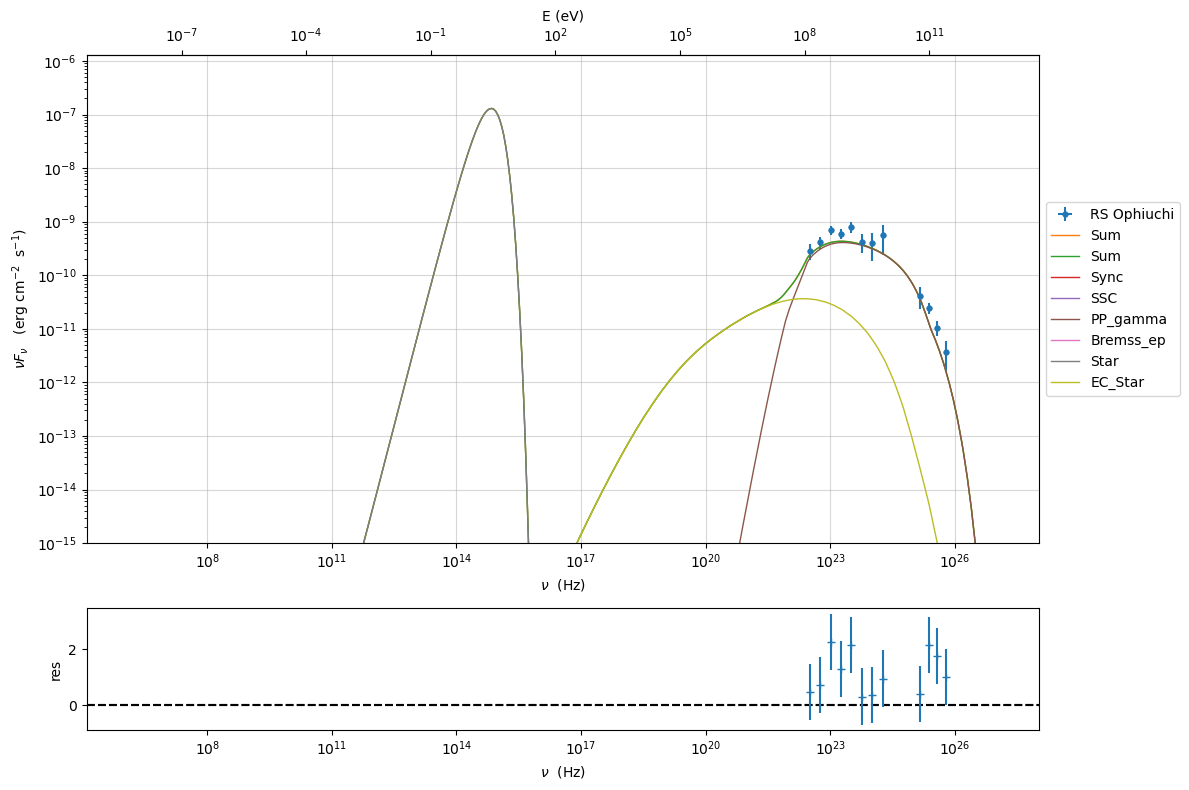

In [8]:
%matplotlib inline
exp_nov_pp=build_nova_expanding_shell(emitters_type='protons',emitters_distribution='plc')
p=None
for t in [3]:
    exp_nov_pp.T_esc_e_second=1*86400 #from Extended Data Fig. 5
    exp_nov_pp.parameters.t.val=t
    exp_nov_pp.parameters.T_Star.val=8460
    exp_nov_pp.parameters.L_Star.val = .5E5*constants.L_sun.cgs.value
    exp_nov_pp.parameters.DL_cm.val=2.45*u.Unit('kpc').to('cm')
    exp_nov_pp.parameters.B.val=1E-3
    exp_nov_pp.parameters.p.val=2.25
    exp_nov_pp.parameters.gamma_cut.val=300
    exp_nov_pp.parameters.gmax.val=1E6
    exp_nov_pp.parameters.NH_pp_ratio.val=0.3E-4
    exp_nov_pp.parameters.E_k.val=5E43
    exp_nov_pp.eval()
    p=exp_nov_pp.plot_model(plot_obj=p,sed_data=sed_data,comp='Sum')
    #I am removing the plot of the neutrino emission
    for c in exp_nov_pp.spectral_components_list:
        if 'neutrino' not in c.name:
            p=exp_nov_pp.plot_model(plot_obj=p,sed_data=sed_data,comp=c.name)
    exp_nov_pp.energetic_report()
    exp_nov_pp.show_pars()
   
    p.add_residual_plot(model=exp_nov_pp,data=sed_data)
    p.setlim(y_min=1E-15)

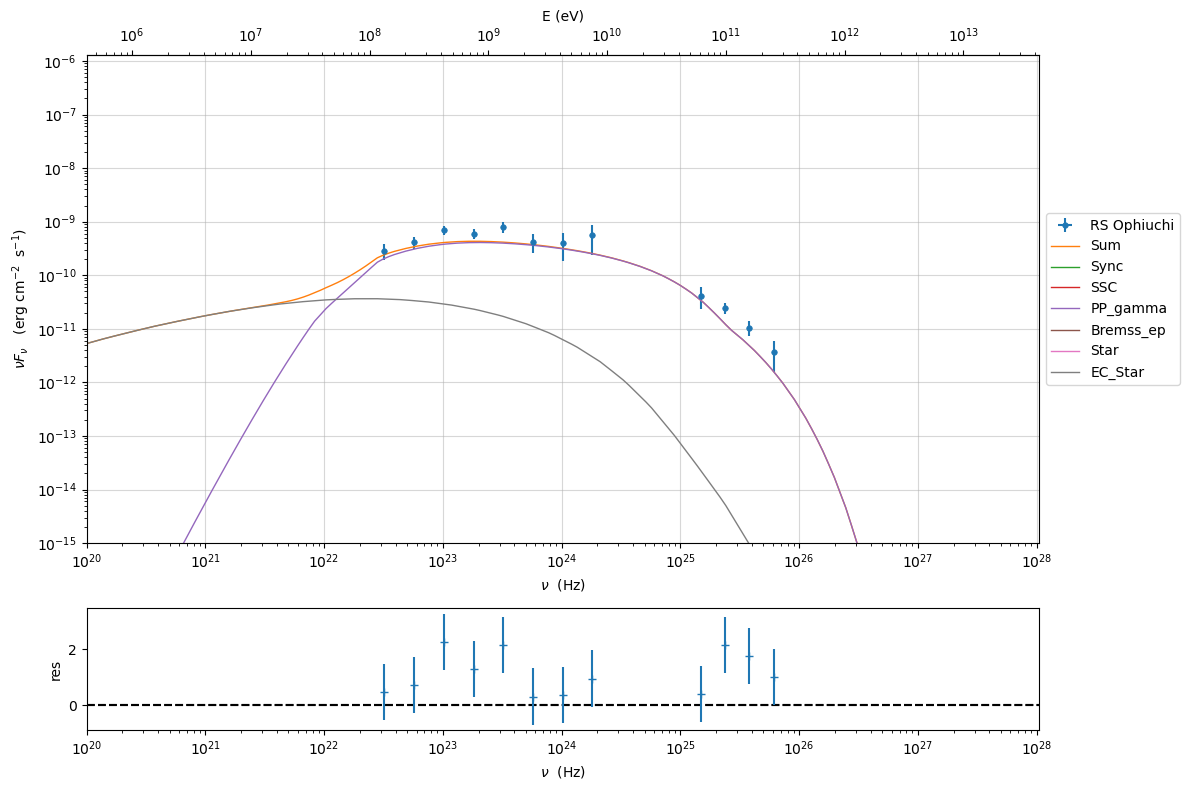

In [9]:
p=None
exp_nov_pp.eval()
for c in exp_nov_pp.spectral_components_list:
    if 'neutrino' not in c.name:
        p=exp_nov_pp.plot_model(plot_obj=p,sed_data=sed_data,comp=c.name)

p.add_residual_plot(model=exp_nov_pp,data=sed_data)
p.setlim(y_min=1E-15,x_min=1E20)


**The EC spectrum is a bit different from the one in the paper, because we are doing quick computation (no solution of the FP equation, but only integral evaluation)of the IC cooling, and we are ignoring the IC suppression. I will try to fix this (by the way, in the jet time evol we do accurate IC cooling with KN suppression)**

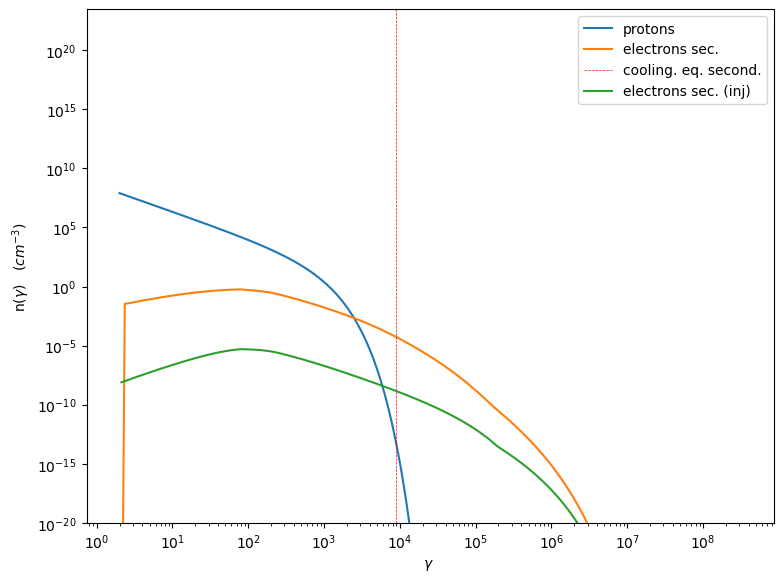

In [10]:
p=exp_nov_pp.emitters_distribution.plot(loglog=False)
p.setlim(y_min=1E-20)

In [11]:
exp_nov_pp.save_model('test.pkl')

In [12]:
from jetset.jet_model import Jet

In [13]:
j=GalacticUnbeamed.load_model('test.pkl')

===> setting C threads to 12
adding par: M_ej to  N
adding par: R_sh to  N
adding par: h_sh to  N
==> par N is depending on ['M_ej', 'R_sh', 'h_sh'] according to expr:   N =
    def par_func_N(M_ej,R_sh,h_sh):
        """ 
        determines the accelerated proton density from M_ej and shell volume
        Eq. 4 in the paper
        
        """
        vol=4/3*np.pi*R_sh**3*((1+h_sh)**3 -1)*u.Unit('cm3')

        N= M_ej.cgs/(vol*constants.m_p.cgs)
        
        return N

adding par: N to  NH_pp
adding par: NH_pp_ratio to  NH_pp
==> par NH_pp is depending on ['N', 'NH_pp_ratio'] according to expr:   NH_pp =
        def par_func_NH_pp(N,NH_pp_ratio):
            """
            This should come form Eq. 5, but I did not find the relevant parameters in the paper.
            Anyhow, the n_ej>>n_target, I paramtrize it as function of n_je i.e. accelerated proton density
            """
            return N*NH_pp_ratio

adding par: t to  R_H_Star
adding par: v_sh to  R_H_Star
==> par R

name,type,units,val
BulkLorentzFactor,jet-bulk-factor,,1.000000e+00
U_e,Energy dens. rest. frame,erg / cm3,5.019236e-02
U_B,Energy dens. rest. frame,erg / cm3,3.978874e-08
U_p,Energy dens. rest. frame,erg / cm3,1.234015e+06
U_p_target,Energy dens. rest. frame,erg / cm3,5.557468e+00
U_Synch,Energy dens. rest. frame,erg / cm3,3.531297e-14
U_Disk,Energy dens. rest. frame,erg / cm3,0.000000e+00
U_BLR,Energy dens. rest. frame,erg / cm3,0.000000e+00
U_DT,Energy dens. rest. frame,erg / cm3,0.000000e+00
U_CMB,Energy dens. rest. frame,erg / cm3,0.000000e+00


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
galactic_unbeamed_hadronic_pp,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
galactic_unbeamed_hadronic_pp,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
galactic_unbeamed_hadronic_pp,"*N(D,h_sh)",emitters_density,1 / cm3,1.232301e+08,0.000000e+00,--,False,True
galactic_unbeamed_hadronic_pp,"*NH_pp(D,NH_pp_ratio)",target_density,1 / cm3,3.696903e+03,0.000000e+00,--,False,True
galactic_unbeamed_hadronic_pp,gamma_cut,turn-over-energy,lorentz-factor*,3.000000e+02,1.000000e+00,1.000000e+09,False,False
galactic_unbeamed_hadronic_pp,p,LE_spectral_slope,,2.250000e+00,-1.000000e+01,1.000000e+01,False,False
galactic_unbeamed_hadronic_pp,L_Star,Star,erg / s,1.914000e+38,0.000000e+00,--,False,False
galactic_unbeamed_hadronic_pp,T_Star,Star,K,8.460000e+03,0.000000e+00,--,False,False
galactic_unbeamed_hadronic_pp,theta_Star,Star,deg,0.000000e+00,0.000000e+00,1.800000e+02,False,False
galactic_unbeamed_hadronic_pp,"*R_H_Star(D,v_sh)",Star,cm,1.200000e+14,0.000000e+00,--,False,True


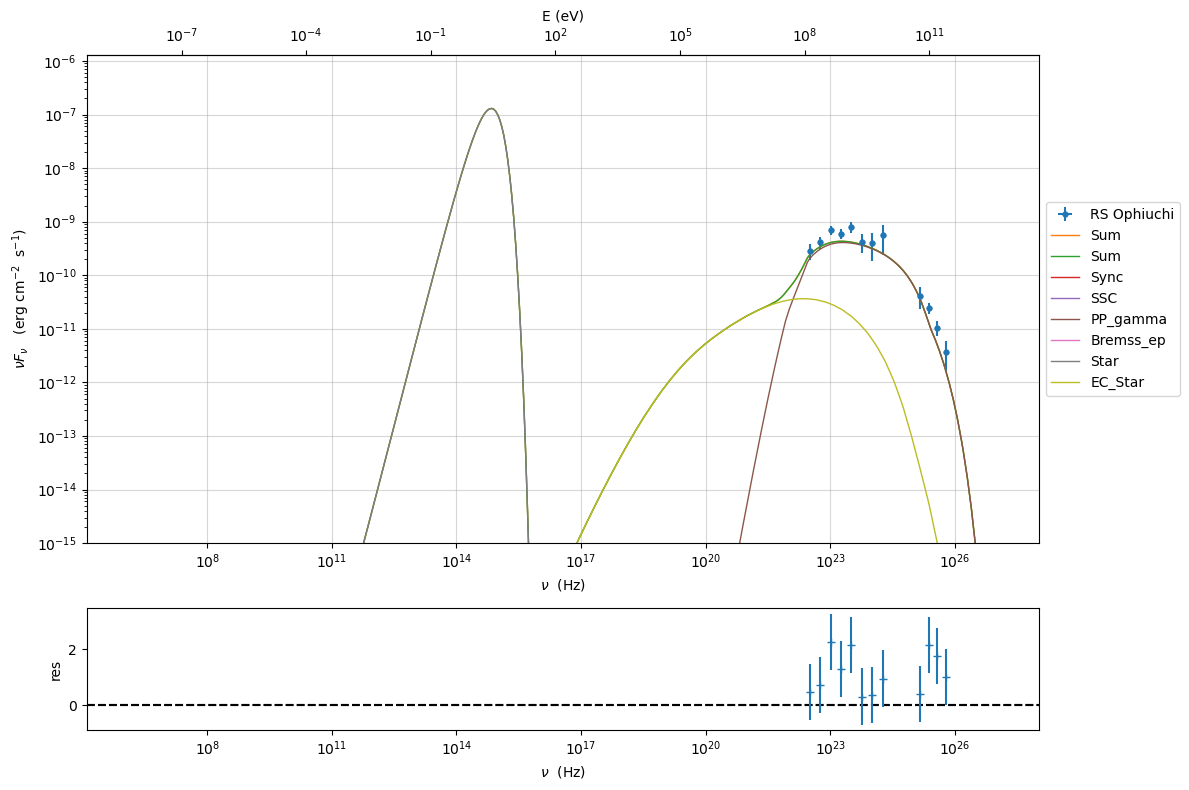

In [14]:
j.eval()
p=None
p=j.plot_model(plot_obj=p,sed_data=sed_data,comp='Sum')
#I am removing the plot of the neutrino emission
for c in j.spectral_components_list:
    if 'neutrino' not in c.name:
        p=j.plot_model(plot_obj=p,sed_data=sed_data,comp=c.name)
j.energetic_report()
j.show_pars()

p.add_residual_plot(model=j,data=sed_data)
p.setlim(y_min=1E-15)